In [1]:
import os

import pandas as pd
import SimpleITK as sitk
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt 

import pyesapi
import atexit

In [2]:
app = pyesapi.CustomScriptExecutable.CreateApplication("test")
atexit.register(app.Dispose)

<bound method 'Dispose'>

In [3]:
def get_direction(image):
    return [image.ZDirection.z,
            image.ZDirection.y,
           image.ZDirection.x,
           image.YDirection.z,
           image.YDirection.y,
           image.YDirection.x,
           image.XDirection.z,
           image.XDirection.y,
           image.XDirection.x]

def get_spacing(image):
    return (image.ZRes,
            image.YRes,
            image.XRes)

def get_origin(image):
    return (image.Origin.z,
            image.Origin.y,
            image.Origin.x)

def get_ct_image(plan):
    ct_np = plan.StructureSet.Image.np_array_like()

    ct_image = sitk.GetImageFromArray(ct_np)
    ct_image.SetSpacing(get_spacing(plan.StructureSet.Image))
    ct_image.SetOrigin(get_origin(plan.StructureSet.Image))
    ct_image.SetDirection(get_direction(plan.StructureSet.Image))
    return ct_image

def get_dose_image(plan):
    constant = plan.TotalDose.Dose / plan.NumberOfFractions /10000/ plan.TreatmentPercentage
    dose_np = plan.Dose.np_array_like()*constant

    
    dose_image = sitk.GetImageFromArray(dose_np)
    dose_image.SetSpacing(get_spacing(plan.Dose))
    dose_image.SetOrigin(get_origin(plan.Dose))
    dose_image.SetDirection(get_direction(plan.Dose))
    return dose_image

def get_structure(plan, structure_id):
    ct = plan.StructureSet.Image
    ct_np = ct.np_array_like()
    z_axis = ct_np.shape[2]
    
    ss = plan.StructureSet.StructuresLot(structure_id)

    mask3d = []
    for i in range(z_axis):
        # Get contour
        contours = ss.GetContoursOnImagePlane(i)

        # create image for draw contour
        img = Image.new("L",(ct_np.shape[0],ct_np.shape[1] ) , 0)

        for contour in contours:
            polygon = [((pt.x - ct.Origin.x)/ct.XRes,(pt.y - ct.Origin.y)/ct.YRes) for pt in contour ]
            ImageDraw.Draw(img).polygon(polygon, outline = 1, fill = 1)

        mask3d.append(np.array(img).T)
    
    # numpy structure
    mask3d = np.array(mask3d)
    mask3d = np.swapaxes(mask3d, 0, 2)
    mask3d = np.swapaxes(mask3d, 0, 1)
    
    mask_image = sitk.GetImageFromArray(mask3d)
    mask_image.SetSpacing(get_spacing(ct))
    mask_image.SetOrigin(get_origin(ct))
    mask_image.SetDirection(get_direction(ct))
    return mask_image
    
def save_patient(patient_id, structure_ids, savepath):
    patient = app.OpenPatientById(patient_id)
    plan = patient.CoursesLot(course_name).PlanSetupsLot(0)
    
    # CT image save in range 0-4XXX
    ct_path = os.path.join(savepath, "ct.nrrd")
    ct_image = get_ct_image(plan)
    sitk.WriteImage(ct_image, ct_path)
    
    # constant for normal plan 


    dose_path = os.path.join(savepath, f"dose.nrrd")
    dose_image = get_dose_image(plan)
    sitk.WriteImage(dose_image, dose_path)

    # save all PlanUncertainties
    dose_count = 1
    for planerror in plan.PlanUncertainties:

        dose_path = os.path.join(savepath, f"dose_{dose_count}.nrrd")
        dose_image = get_dose_image(planerror)
        sitk.WriteImage(dose_image, dose_path)
        dose_count +=1
        
    
    # Save structure
    for key, value in zip(structure_ids.keys(), structure_ids.values):
        
        maskpath = os.path.join(savepath, f"ss_{key}.nrrd")
        mask_image = get_structure(plan, value)
        sitk.WriteImage(mask_image, maskpath)
        
        
    app.ClosePatient()

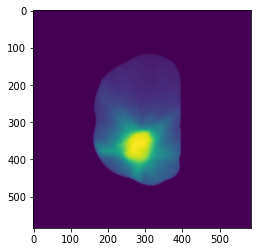

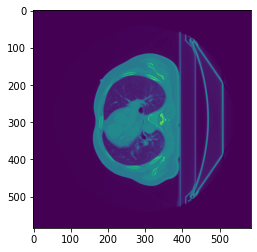

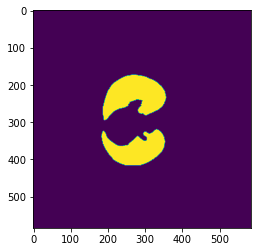

In [7]:
try:
    patient_id = "4362017"
    course_name = "D_IMRT_research"
    roi_name = "Lung_sum"
    
    patient = app.OpenPatientById(patient_id)
    
    # Get the first plan
    plan = patient.CoursesLot(course_name).PlanSetupsLot(0)
    ct_image = get_ct_image(plan)

    dose_image = get_dose_image(plan)
    dose_image = sitk.Resample(dose_image, ct_image)
    
    mask_image = get_structure(plan, roi_name)
    
    #slide number
    n = 50
    dose = sitk.GetArrayFromImage(dose_image)
    plt.imshow(dose[:,:,n])
    plt.show()
    
    ct = sitk.GetArrayFromImage(ct_image)
    plt.imshow(ct[:,:,n])
    plt.show()
    
    mask = sitk.GetArrayFromImage(mask_image)
    plt.imshow(mask[:,:,n])
    plt.show()

finally:
    app.ClosePatient()
    
